# This notebooks does predictive modeling of the Output : "Is there any potential Microbial Activity?" in the FSHA form 
# This notebook applies basic ML techniques like NaiveBayesClassifier, LogisticRegression, SGDClassifier on the concatenated text derived from the set of features. The text is cleaned, normalized and then vectorized and fit into the Model. The target is upsampled to counter the unbalanced data ('Yes' / 'No' values), before applying ML

In [1]:
import logging
import pandas as pd
import numpy as np
from numpy import random
import nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import re
from bs4 import BeautifulSoup
import warnings
warnings.simplefilter('ignore')
%matplotlib inline

In [2]:
#filename = "C:/Pepsico/FSHA RPA - 25 July 2019 - 209Files.xlsm"
filename1 = "C:/Pepsico/NAF-2019 RPA - 09 AUGUST 2019.xlsm"
filename2 = "C:/Pepsico/NAF-2018 RPA - 09 AUGUST 2019.xlsm"
filename3 = "C:/Pepsico/Additional FSHAs.xlsm"
filename4 = "C:/Pepsico/FSHA RPA - Microbial Growth = Y - 14 Aug 2019.xlsm"
#filename4 = "C:/Pepsico/NAF - Additional FSHAs 1 - 13 AUG 2019.xlsm"

In [3]:
df1 = pd.read_excel(filename1)
df2 = pd.read_excel(filename2)
df3 = pd.read_excel(filename3)
df4 = pd.read_excel(filename4)

In [4]:
df =  pd.concat([df1,df2,df3,df4])

In [5]:
len(df)

119

# Read the extract file, check the number of records, first few rows

In [6]:
#df = pd.read_excel(filename)

In [15]:
df.iloc[0,:40]


File Name               Cheetos Double Cheddar Eggs Combined FSHA Form...
projName                         Cheetos Double Cheddar Egg Puff LTO 2019
accolNumber                                                         52607
PDA_projName                   Cheetos Eggs Double Cheddar flavored Puffs
projType                                                          Refresh
projDesc                Launch a legacy Double Cheddar seasoning (ING9...
formulaNumber                                                  FFM0008310
owner                                                         Ann Robarge
sector                                                               FLNA
center                                                              Plano
Current TSG Stage                                                    GTSU
FSAssessors                                          Chantal Nde, Sun Lee
FSDate                                                2018-07-23 00:00:00
WHTD                                  

# Select key features 

In [16]:
#features_df=df[['preservatives', 'pH', 'waterActivity', 'packaging','otherFSA',
#            'prodStorageDist', 'foodSafetyProdClaims','targetMarket','allergens','newIngredient','allergensLabeledIMAF']]
df.fillna('NA', inplace=True)
features_df=df[['projDesc','PDA_projName','packMaterial', 'CPD-ProdName','CPD-ProdName-Desc','TCG', 'labelingInstructions',
        'mishandled', 'targetMarket']]


In [17]:
def conv_str(x):
   
    x=str(x)
    x=x.lower()
    return (x)

features_df['projDesc']=features_df['projDesc'].apply(lambda x:conv_str(x))  
features_df['PDA_projName']=features_df['PDA_projName'].apply(lambda x:conv_str(x))
features_df['packMaterial']=features_df['packMaterial'].apply(lambda x:conv_str(x))  
features_df['CPD-ProdName']=features_df['CPD-ProdName'].apply(lambda x:conv_str(x))  
features_df['CPD-ProdName-Desc']=features_df['CPD-ProdName-Desc'].apply(lambda x:conv_str(x))  
features_df['TCG']=features_df['TCG'].apply(lambda x:conv_str(x)) 
features_df['labelingInstructions']=features_df['labelingInstructions'].apply(lambda x:conv_str(x)) 
features_df['mishandled']=features_df['mishandled'].apply(lambda x:conv_str(x))  
features_df['targetMarket']=features_df['targetMarket'].apply(lambda x:conv_str(x))  




# Concatenate the columns as one single text value

In [18]:
features_df['concat_text'] = features_df['projDesc']+" "+features_df['packMaterial']+" "+features_df['PDA_projName']+" "+features_df['CPD-ProdName']+" "+features_df['CPD-ProdName-Desc']+" "+features_df['TCG']+" "+features_df['labelingInstructions']+" "+features_df['mishandled']+" "+features_df['targetMarket']
#features_df['newIngredient']+" "+features_df['allergens']+" "+features_df['allergensLabeledIMAF']+" "+


# Find the number of tokens in the text

In [19]:
features_df['concat_text'].apply(lambda x: len(x.split(' '))).sum()

9120

We have over 15k words in the data.

# Find the value counts of target Field (Yes / No)

In [21]:
df.chokeHazard.value_counts()

No     109
NA       6
Yes      4
Name: chokeHazard, dtype: int64

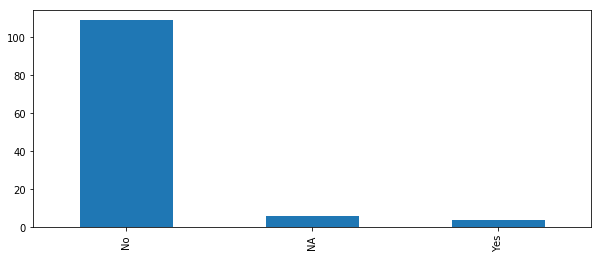

In [23]:
plt.figure(figsize=(10,4))
df.chokeHazard.value_counts().plot(kind='bar');

# Binarize the target, impute any missing value with the mode

In [24]:
import statistics 

def impute_target(fsha_data,targetName):
    train_y=[]
    #print(len(fsha_data))
    for i in range (len(fsha_data)):
        #print(i)
        ##print(fsha_data[targetName].values(i))
        if fsha_data[targetName].values[i]=='Yes':
            train_y.append(1)
        elif fsha_data[targetName].values[i]=='No':
            train_y.append(0)
        else:
            train_y.append(-1)
               
    mode_y = statistics.mode(train_y)

    for i in range (len(fsha_data)):
        if train_y[i]==-1:
            train_y[i] = mode_y
            
    return train_y

In [25]:
#df['potentialMicrobial'].fillna('NA', inplace=True)
features_df["tags"] = impute_target(df,"chokeHazard")
#df['potentialMicrobial'][:50]
#impute_target(df,"potentialMicrobial")

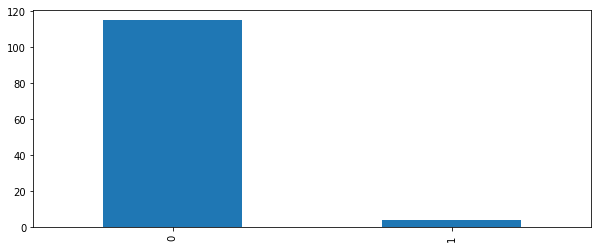

In [26]:
plt.figure(figsize=(10,4))
features_df.tags.value_counts().plot(kind='bar');

In [27]:
features_df.tags.value_counts()

0    115
1      4
Name: tags, dtype: int64

The classes are not balanced, but we see higher count of 1, based on new data

In [28]:
def print_plot(index):
    example = features_df[features_df.index == index][['concat_text', 'tags']].values[0]
    if len(example) > 0:
        print(example[0])
        print('Tag:', example[1])

# Have a look a few concatenated text and target pairs.

In [29]:
print_plot(10)

salsa verde was launched in 2014 as a regional launch. revisions have been done to the 2014 recipe to include roasted tomatoes, cilantro flavor and new product is now designed for a nation wide launch.  glass jar tostitos salsa verde tostitos salsa verde hot fill salsa  gen population  refrigerate after opening no no
Tag: 0


In [30]:
print_plot(5)

new seasoning rrd ngm swt chili sc seas (ing0001937) on existing red rock deli pc base none rrd sweet chili and sour cream red rock deli sweet chili and sour cream red rock deli potato chips general population none no no
Tag: 0


# Clean the text (remove punctuation, symbols, lowercase etc)

In [31]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = BeautifulSoup(text, "lxml").text # HTML decoding
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = BAD_SYMBOLS_RE.sub('', text) # delete symbols which are in BAD_SYMBOLS_RE from text
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # delete stopwors from text
    return text

In [32]:
features_df['concat_text'] = features_df['concat_text'].apply(clean_text)

# Check a sample row of cleaned text

In [33]:
print_plot(0)

launch legacy double cheddar seasoning ing9000249 30033268 eggshaped puffs base spring 2019 lto event product made current copacker shearers foods none cheetos eggs double cheddar flavored puffs cheetos eggs double cheddar flavored puffs snacks savory snacks eggshaped directexpanded corn meal base baked topically seasoned oilbased slurry general population none
Tag: 0


In [34]:
features_df['concat_text'].apply(lambda x: len(x.split(' '))).sum()

5513

# Train Test Split

In [35]:
X = features_df.concat_text
y = features_df.tags
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y,random_state = 42)

In [36]:
y_train.value_counts()

0    92
1     3
Name: tags, dtype: int64

In [37]:
y_test.value_counts()

0    23
1     1
Name: tags, dtype: int64

In [38]:
y_test = y_test.reset_index()
y_test = y_test['tags']

# Upsample the target data, since the data is highly imbalanced

In [39]:
from sklearn.utils import resample

# concatenate our training data back together
X = pd.concat([X_train, y_train], axis=1)

# separate minority and majority classes
not_potMicrobial = X[X.tags==0]
potMicrobial = X[X.tags==1]

In [40]:
len(not_potMicrobial)

92

In [41]:
len(potMicrobial)

3

In [42]:
# upsample minority
potMicrobial_upsampled = resample(potMicrobial,
                          replace=True, # sample with replacement
                          n_samples=len(not_potMicrobial), # match number in majority class
                          random_state=27) # reproducible results

# combine majority and upsampled minority
upsampled = pd.concat([potMicrobial_upsampled, not_potMicrobial])

In [43]:
# check new class counts - now we have balanced data
upsampled.tags.value_counts()

1    92
0    92
Name: tags, dtype: int64

In [44]:
y_train = upsampled.tags
X_train = upsampled.drop('tags', axis=1)

In [45]:
y_train=y_train.reshape(y_train.shape[0],1)

In [46]:
y_train.shape

(184, 1)

In [47]:
X_train.shape

(184, 1)

In [48]:
X_train['concat_text'].values[5]

'oil roasted unsalted peanuts na munchies unsalted peanuts munchies unsalted peanuts salted nuts whole jumbo runner peanuts blanched oil roasted vegetable oil general population none'

In [49]:
X_train = X_train['concat_text'].values

In [50]:
X_train[5]

'oil roasted unsalted peanuts na munchies unsalted peanuts munchies unsalted peanuts salted nuts whole jumbo runner peanuts blanched oil roasted vegetable oil general population none'

In [51]:
X_test.values[0]

'imagne cheese stars cheese wheatbased crackers produced rbs line pulaski tn changes processing line include new ingredients cheese whey protein concentrate new rotary cutter new weigh belt system used feed cubed cheese continuous mixer new bucket conveyor used transport cubed cheese weigh belt system trade call production slated 1x2 2018 full scale production slated begin p4 2018 ffm0008160 parmesan ffm0008159 white cheddar none imagne cheese stars formerly known cheese pops imagne cheese stars baked expanded crackers contains cheese wheat flour minor ingredients ingredients mixed water form dough sheeted cut baked dried packaged general population none'

In [52]:
X_test = X_test.values

In [55]:
X_test[5]

'new launch p2 2019 lktl nat lts wht chdr seas 30050021 none lays kettle cooked lightly salted white cheddar lays kettle cooked lightly salted white cheddar fried kettle pc lightly saltedwhite cheddar seasoning general population none'

In [56]:
y_train[5]

array([1], dtype=int64)

The next steps includes feature engineering. We will convert our text documents to a matrix of token counts (CountVectorizer), then transform a count matrix to a normalized tf-idf representation (tf-idf transformer). After that, we train several classifiers. 

### Naive Bayes classifier for multinomial models

In [57]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer

nb = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB()),])
nb.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip...inear_tf=False, use_idf=True)), ('clf', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])

In [58]:
%%time
from sklearn.metrics import classification_report,f1_score
y_pred = nb.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test).round(2))
print('f1-score %s' % f1_score(y_pred, y_test,average='weighted').round(2))
print(classification_report(y_test, y_pred))

accuracy 0.92
f1-score 0.9
             precision    recall  f1-score   support

          0       1.00      0.91      0.95        23
          1       0.33      1.00      0.50         1

avg / total       0.97      0.92      0.94        24

Wall time: 15.6 ms


In [59]:
X = np.concatenate((X_train,X_test))

In [60]:
len(X)

208

In [61]:
X=X.reshape(X.shape[0],)

In [62]:
y_test=y_test.reshape(y_test.shape[0],1)

In [63]:
y = np.concatenate((y_train,y_test))

In [64]:
y=y.reshape(y.shape[0],)

after fit


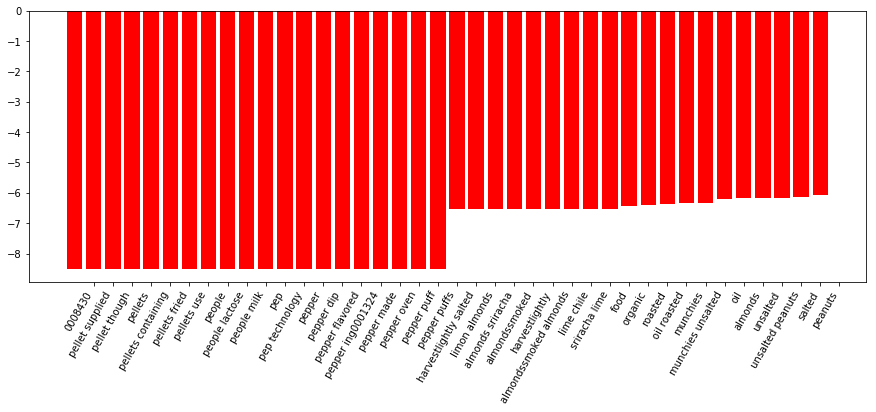

In [71]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import LinearSVC
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer


def plot_coefficients(classifier, feature_names, top_features=20):
 coef = classifier.coef_.ravel()
 top_positive_coefficients = np.argsort(coef)[-top_features:]
 top_negative_coefficients = np.argsort(coef)[:top_features]
 top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
 # create plot
 plt.figure(figsize=(15, 5))
 colors = ['red' if c < 0 else 'blue' for c in coef[top_coefficients]]
 plt.bar(np.arange(2 * top_features), coef[top_coefficients], color=colors)
 feature_names = np.array(feature_names)
 plt.xticks(np.arange(1, 1 + 2 * top_features), feature_names[top_coefficients], rotation=60, ha='right')
 plt.show()


tfidf = TfidfVectorizer(sublinear_tf=True, ngram_range=(1, 2))
features = tfidf.fit_transform(X)

nb = MultinomialNB()
nb.fit(features, y)
print("after fit")
plot_coefficients(nb, tfidf.get_feature_names())

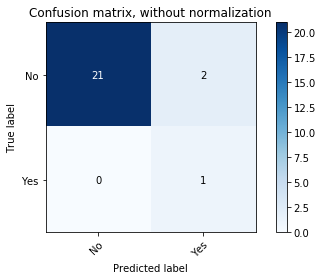

In [68]:
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
   # else:
        #print('Confusion matrix, without normalization')

    #print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

class_names=['No','Yes']
# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
#plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True,
#                      title='Normalized confusion matrix')

plt.show()

In [72]:
nb = Pipeline([('vect', CountVectorizer(ngram_range=(1,2))),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB()),])
cv_results = cross_validate(nb.fit(X, y), X, y,cv=5)

In [73]:
print(cv_results['test_score'])

[0.98 0.98 0.98 1.   0.98]


In [74]:
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_validate
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import ShuffleSplit
#We define custom functions to return count of TP,TN,FP,FN for each fold
def tn(y_true, y_pred): return confusion_matrix(y_true, y_pred)[0, 0]
def fp(y_true, y_pred): return confusion_matrix(y_true, y_pred)[0, 1]
def fn(y_true, y_pred): return confusion_matrix(y_true, y_pred)[1, 0]
def tp(y_true, y_pred): return confusion_matrix(y_true, y_pred)[1, 1]

scoring = {'tp': make_scorer(tp), 'tn': make_scorer(tn),'fp': make_scorer(fp), 'fn': make_scorer(fn)}
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=42)

nb = Pipeline([('vect', CountVectorizer(ngram_range=(1,2))),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB()),])
cv_results = cross_validate(nb.fit(X, y), X, y,scoring=scoring, cv=cv)

In [100]:
print(cv_results['test_tp'])  
print(cv_results['test_tn']) 
# Getting the test set false negative scores
print(cv_results['test_fn'])  
print(cv_results['test_fp']) 

[17 16 16 16 16]
[20 18 19 19 19]
[0 0 0 0 0]
[0 2 0 0 0]


In [75]:
print("Count of True Positives")
print(cv_results['test_tp']) 
print("Count of True Negatives")
print(cv_results['test_tn']) 
# Getting the test set false negative scores
print("Count of False Negatives")
print(cv_results['test_fn']) 
print("Count of False Positives")
print(cv_results['test_fp']) 

Count of True Positives
[14 21 18 17 17]
Count of True Negatives
[28 19 23 23 23]
Count of False Negatives
[0 0 0 0 0]
Count of False Positives
[0 2 1 2 2]


### SGDClassifier

In [76]:
from sklearn.linear_model import SGDClassifier

sgd = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None)),
               ])
sgd.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip...ty='l2', power_t=0.5, random_state=42, shuffle=True,
       tol=None, verbose=0, warm_start=False))])

In [77]:
%%time

y_pred = sgd.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test).round(2))
print('f1-score %s' % f1_score(y_pred, y_test,average='weighted').round(2))
print(classification_report(y_test, y_pred))

accuracy 0.96
f1-score 0.98
             precision    recall  f1-score   support

          0       0.96      1.00      0.98        23
          1       0.00      0.00      0.00         1

avg / total       0.92      0.96      0.94        24

Wall time: 17.6 ms


### Logistic regression

In [78]:
from sklearn.linear_model import LogisticRegression

logreg = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(n_jobs=1, C=1e5)),
               ])
logreg.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip...ty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False))])

In [79]:
%%time

y_pred = logreg.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test).round(2))
print('f1-score %s' % f1_score(y_pred, y_test,average='weighted').round(2))
print(classification_report(y_test, y_pred))

accuracy 0.96
f1-score 0.98
             precision    recall  f1-score   support

          0       0.96      1.00      0.98        23
          1       0.00      0.00      0.00         1

avg / total       0.92      0.96      0.94        24

Wall time: 15.6 ms
